<font size=8>Reducción dimensional</font>

In [1]:
# Para que ande tanto en python 2 cuanto en python 3
from __future__ import division, print_function, unicode_literals

# Importaciones comunes
import numpy as np
import os, sys

%matplotlib inline
import matplotlib.pyplot as plt

# Para que la salida de este notebook sea la misma en distintas ejecuciones
np.random.seed(42)

# Para hacer lindas gráficas
import matplotlib as mpl
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Donde grabar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "11_Unsupervised"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignorar advertencias (warnings) inútiles (ver el SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")


# Reducción de dimensionalidad

Trabajar en espacios de gran dimensionalidad, lo que es lo mismo, trabajar con datos con muchas features o campos, es frecuentemente inconveniente o incluso imposible. Uno puede querer reducir la dimensionalidad con vistas a:
* hacer visualizaciones
* ahorrar espacio ocupado por los datos (compresión)
* reducir los costos computacionales de entrenamiento de algoritmos, reduciendo el número de características
* aumentar la performance de un modelo aumentando la relación señal/ruído, así como la densidad de puntos (*evitar la maldición de la dimensionalidad*).

Al problema de reducir la dimensionalidad de las características, mientras se retiene la mayor parte de la información se lo conoce como *reducción de la dimensionalidad* y hay dos enfoques principales para atacarlo:
* Proyección: proyectar el espacio de muchas dimensional a un plano, eliminando las características ortogonales a él
* Aprendizaje de variedad (*Manifold-Learning*): aprender la geometría de una variedad de menor dimensionalidad y proyectar los datos en ella

En la primera categoría, el algoritmo más conocido es el de Análisis de Componentes Principales.

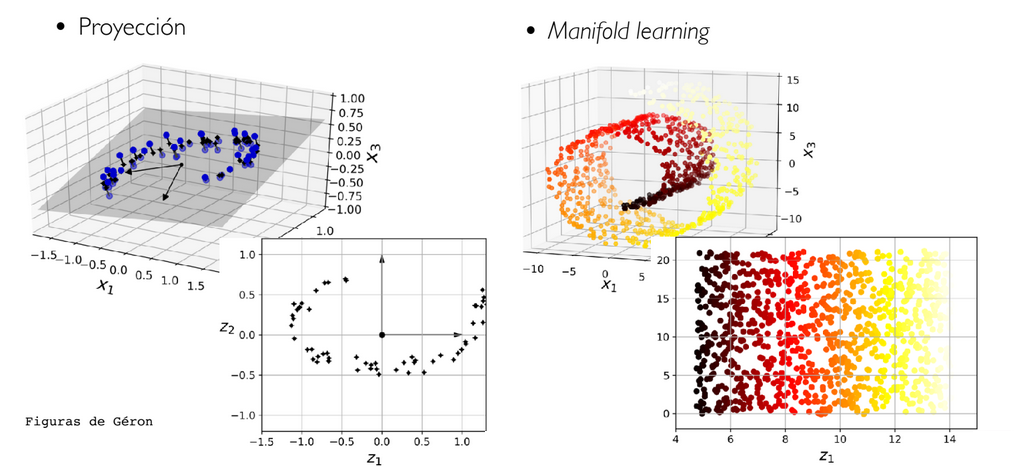

## Análisis de Componentes Principales - *Principal Component Analysis*

El objetivo del Análisis de Componente Principales es encontrar las direcciones sobre las cuales proyectar los datos de forma a minimizar la pérdida de infromación al reducir la dimensionalidad.

Veremos eso en acción, pero antes démosle una mirada más intuitiva e ingenua al problema, a partir de un ejemplo simplificado.

### Enfoque ingenuo a la reducción dimensional


Vamos a crear un conjunto de datos fictício, de puntos en 2 dimensiones (2D) y vamos a suponer que, por alguna razón, queremos reducir los datos a una única dimensión. O sea, cada instancia de datos $x$ es representada por dos números reales, y queremos construir un conjunto aproximado de datos en un espacio unidimensional, o sea, cada nueva instancia $z$ será representada por un único número.

En principio uno podría quedarse con una sóla de las dimensiones y descartar las otras, pero en general la pérdida de información va a ser muy grande. La idea en cambio es tratar de hacer alguna combinación de las componentes de las distintas dimensiones tal que esa combinación describa razonablemente los datos.

Salvo en situaciones muy específicas, como cuando los valores de una dimensión están directamente relacionados con las otras (por ej. $x = (a, 2a)$, o sea, el segundo valor es el doble del primero), siempre vamos a perder alguna información haciendo eso. El juego es encontrar la forma de elegir ese único número que reduzca esa perdida de información.

Empecemos.

**Crear un conjunto de datos 2D a partir de una distribución normal homogénea y hacerla rotar**

Dimension del array de datos: (200, 2)


Text(0, 0.5, '$X_2 (base)$')

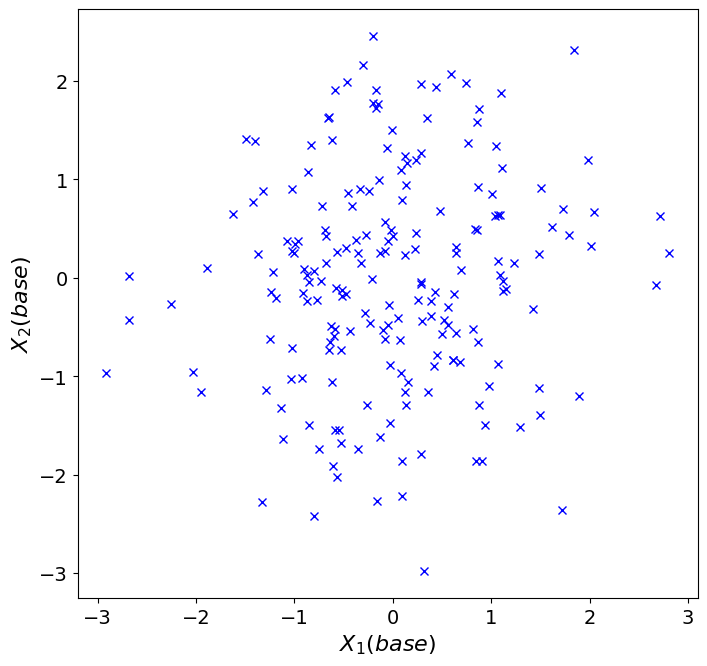

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Crear dats independientes con distribución gaussiana (200 puntos)
m = 200
np.random.seed(3)
X_base = np.random.randn(m, 2)

# Verificar la dimensión del array (matriz) resultante
print('Dimension del array de datos:', X_base.shape)

# Miremos el conjunto de datos que creamos
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_base.T, marker='x', color='b', ls='')
ax.set_aspect('equal')
ax.set_xlabel('$X_1 (base)$', fontsize=16)
ax.set_ylabel('$X_2 (base)$', fontsize=16)

In [ ]:
# Definir el angulo por el cual vamos a rotar los datos y el factor por el cual los estiraremos
angle = np.pi / 8
stretch = 5

# Matriz de estiramiento (deformación)
S = np.array([[stretch, 0],
              [0, 1]])

# Matriz de rotación
R = np.array([[np.cos(angle), np.sin(angle)],
              [-np.sin(angle), np.cos(angle)]])

# Estiramiento (usamos el operador @ de numpy para mulriplicar vector * matriz)
X = X_base @ S
# Rotación
X = X @ R

In [ ]:
# Miremos el conjunto de datos resultante
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X.T, marker='x', color='k', ls='')
ax.set_aspect('equal')
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

Evidentemente, esos son solo números aleatorios en 2D. Vamos a suponer que centramos los datos sustrayendo el promedio de cada eje (por eso los datos están centrados en 0.0).

Pueden pensar en un par de ejemplos de conjuntos de datos donde esa situación puede existir:

* altura versus peso de una muestra de personas para una dada población
* precio de algún bien versus la demanda por ese bien

**¿Pueden pensar en uno o dos ejemplos adicionales?**

Como dijimos antes, una forma de reducir la dimensionalidad de ese conjunto de datos sería simplemente **quitar una de las dimensiones**.

### Descartando una dimensión

Podemos ver los histogramas de la proyección de los datos en los ejes $x$ e $y$

In [ ]:
ax = plt.figure(figsize=(10, 5)).add_subplot(111)

ax.hist(X[:, 0], label='$x_1$', color='orange', bins=25)
ax.hist(X[:,1], label='$x_2$', color='lightblue', bins=25)
ax.legend(loc=0, fontsize=17)


Claramente **ninguna de esas dos direcciones** es buena.

**¿Pueden imaginar las direcciones que piensan que producirían una mejor conservación de la información de los datos? ¿Por qué?**

### *Proyección en las diagonales

Mirando a los datos, parece tener sentido **proyectarlos en las direcciones diagonales** y quedarse con solo una de ellas. Hay dos diagonales, entonces hagamos las dos proyecciones y veamos cual funcional mejor.

In [ ]:
variant_1 = X[:, 0] + X[:, 1] # x + y
variant_2 = X[:, 0] - X[:, 1] # x - y

In [ ]:
# Miremos los conjuntos de datos resultantes
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

imin = np.argmin(X[:, 0])
imax = np.argmax(X[:, 0])

ax.plot([X[imin, 0], X[imax, 0]], [X[imin, 0], X[imax, 0]], ls=':', color='gray')
ax.plot([X[imin, 0], X[imax, 0]], [-X[imin, 0], -X[imax, 0]], ls=':', color='gray')

# Annotate new axes
ax.annotate('$z_1$', [X[imax, 0], X[imax, 0]], fontsize=16)
ax.annotate('$z_2$', [X[imax, 0], -X[imax, 0]], fontsize=16)

# Saque los comentários en estas dos lineas para hacer gráficas de las proyecciones
# ax.plot(0.5*variant_1, 0.5*variant_1, 'x', color='orange', ls='')
# ax.plot(0.5*variant_2, -0.5*variant_2, 'x', color='lightblue', ls='')

# Labels
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

Ahora veamos como quedan los histogramas de la proyección de los datos en las diagonales ($z_1$ y $z_2$)

In [ ]:
ax = plt.figure(figsize=(10, 5)).add_subplot(111)

ax.hist(variant_1, label='$z_1$', color='orange', bins=25)
ax.hist(variant_2, label='$z_2$', color='lightblue', bins=25)
ax.legend(loc=0, fontsize=17)

ax.set_xlabel('$z$', fontsize=16)

Vemos que hay una dirección en que los datos tienen más dispersión que en la otra y probablemente preserve más información.
Esa sería una buena candidata para escoger como $z$.

**¿Cual de las dos opciones elegirían?**

### Ejecutando PCA

La principal finalidad del Análisis de Componentes Principales, PCA (de *Principal Component Analysis*) es encontrar el conjunto óptimo de ejes sobre los cuales proyectar los datos disponibles. Cada una de las direcciones de esos ejes es llamada de Componente Principal.

En PCA la elección de los ejes más importantes se hace según su varianza. La primera Componente Principal es la dirección que continene la mayor parte de la varianza de los datos. Otras direcciones son encontradas (tantas cuanto el número de dimensiones, o sea, características, en el conjunto de datos), con la condición de que cada componente sucesiva retenga la mayor parte posible de la varianza que queda y que sea ortogonal a todas las anteriores.

En otras palabras, el algoritmo ajusta un elipsoide a los datos y entonces rota los ejes para que estén alineados con los ejes principales del elipsoide. Los ejes rotados son las componentes principales. *(Para las personas que les gusten el álgebra lineal, esto es equivalente a encontrar una base ortogonal en la que la matriz de covarianza es diagonalizada).*

Veamos la implementación en `sklearn`.

En este caso estamos lidiando con una clase conocida como `Transformer` (no confundir con los modelos de *Deep Learning* de mismo nombre que están en voga en la actualidad). En `sklearn`, esas clases tienen un método `.fit` (ajustar) que toman un conjunto de datos como argumento y aprende algunos parámetros a partir de él. En este caso, el método aprende la matriz de covarianza a partir de los datos y como invertirla. También tienen un método `transform` (transformar) que usa los parámetros aprendidos para hacer una transformación en el conjunto de datos. En este caso, convierte el conjunto de datos original en el conjunto reducido.

Finalmente, el método `fit_transform` concatena los dos pasos.

**Es importante para hacer PCA que el conjunto de datos esté normalizado**. Para eso usaremos otro *transformer*, el `StandardScaler`.

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Instanciar el escalonador y escalonar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encuentra los componentes principales (¿cuántas componentes queremos?)
pca = PCA(n_components=1) # n_components: número de componentes con las que nos quedamos
X_pca = pca.fit_transform(X_scaled)

NameError: ignored

**Exploren la forma de la salida. ¿Tiene sentido?**

In [ ]:
print(X.shape, X_pca.shape)

Las coordenadas de los ejes elegidos para proyectar (o sea, los componentes principales) son guardados en el atributo `components_` en cada línea.

In [ ]:
pca.components_.shape

**Veamos esas direcciones en la gráfica de arriba**

In [ ]:
# Miremos el conjunto de datos resultante
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

z = pca.components_

for i in range(len(z)):
    #
    # dirección del componente (inclinación)
    m = z[i, 0] / z[i, 1]

    # Graficar línea
    ax.plot([X_scaled[imin, 0], X_scaled[imax, 0]],
            [X_scaled[imin, 0] * m, X_scaled[imax, 0] * m],
            ls=':', color='gray')

    # Graficar flechas
    size=0.5
    ax.arrow(0, 0, z[i, 0]*size, z[i,1]*size, color='C{}'.format(i+1), width=0.1, head_width=0.3, alpha=0.8,
             label='Primer componente principal')

    # Anotar nuevos ejes
    ax.annotate('$z_{}$'.format(i+1), [X_scaled[imin, 0], X_scaled[imin, 0]*m], fontsize=16, color='C{}'.format(i+1))

# Quitar los comentários a estas líneas para graficar proyecciones en la primer Componente Principal (definir como cero en el segundo componente)
# X_pca_cut = X_pca.copy()
# X_pca_cut[:,1]=0
# X_1 = pca.inverse_transform(X_pca_cut)
# ax.plot(*X_1.T, 'x', color='orange', ls='')

# Labels
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)
ax.legend()

### *Un poquito de álgebra

Calculemos (numéricamente) la matriz de covarianza del conjunto original de datos

Ahora miremos a la matriz de covarianza de las coordenadas transformadas.

In [ ]:
# Encuentra las componentes principales (cuantas componentes queremos?)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(np.cov(X_pca.T).round(2))

Noten dos cosas:
1. la matriz de covarianza es ahora diagonal
2. la mayor parte de la varianza está en la primera coordenada (PCA ordena automaticamente las características por su varianza).

### *Datos en los ejes transformados

Text(0, 0.5, '$z_2$')

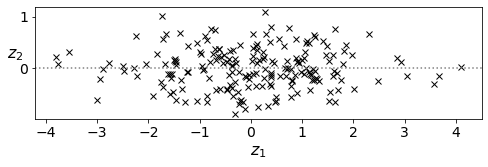

In [ ]:
# En los ejes transformados, los datos se parecen a un elipsóide alineado
ax = plt.figure(figsize=(8, 8)).add_subplot(111)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
ax.plot(*X_pca.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

ax.axhline(0.0, color='gray', ls=':')

# Nombres de los ejes
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)

**Pregunta**. Volviendo a los ejemplos de uso de arriba (altura versus peso, etc.). ¿Pueden decir qué es lo que cada nueva coordenada $z$ representa?


Podemos volver facilmente al espacio original usando el método `inverse_transform`. Note que el código chequea si la reconstrucción se ha hecho correctamente (es decir, si la reconstrucción es perfecta, o si se perdió información en el proceso).

In [ ]:
X_reconstructed = pca.inverse_transform(X_pca)

print('La reconstruccuión está perfecta? {}'.format('Sí' if np.allclose(X_scaled, X_reconstructed) else 'No'))

**Pregunta**. ¿Perdimos alguna información al ir al espacio de PCA y volver? ¿Hemos reducido la dimensionalidad del conjunto de datos?

### Reconstrucción incompleta

Ir al espacio PCA y volver no es una tarea de reducción de dimensionalidad y, por lo tanto, no conlleva a ninguna pérdida de información. Veamos qué ocurre si solo mantenemos la proyección de los datos en la primera componente principal.

In [ ]:
# Ejecutar PCA en un solo componente
pca = PCA(n_components=1)
X_pca_1D = pca.fit_transform(X_scaled)

Si hacemos la transformada inversa, veremos que alguna información se ha perdido, de forma que los datos invertidos no son los mismos que los originales:

In [ ]:
X_reconstructed = pca.inverse_transform(X_pca_1D)
print('La reconstrucción es perfecta? {}'.format('Sí' if np.allclose(X_scaled, X_reconstructed) else 'No'))

Miremos a esos datos comprimidos:

In [ ]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='', label='Datos originales')
ax.plot(*X_reconstructed.T, marker='x', color='orange', ls='', label='Reconstruídos')
ax.legend(fontsize=16)
ax.set_aspect('equal')

**Esto** es exactamente la proyección en la dirección definida por el primer componente principal. De esa forma, el conjunto resultante comprimido retiene la mayor varianza posible.

Si miramos a la matriz de covarianza, veremos que no se ha perdido mucho:

In [ ]:
print('Matriz de covarianza original\n', np.cov(X_scaled.T))
print('\nMatriz de covarianza comprimida\n', np.cov(X_reconstructed.T))

Matriz de covarianza original
 [[1.00502513 0.85070879]
 [0.85070879 1.00502513]]

Matriz de covarianza comprimida
 [[0.92786696 0.92786696]
 [0.92786696 0.92786696]]


La fracción de la varianza (información) total retenida por cada componente principal es almacenada en el atributo `explained variance_ratio_`:

In [ ]:
pca.explained_variance_ratio_

array([0.92322762])

¡Eso muestra que la proyección en la dirección de la primer componente principal retiene más de 92% de la varianza de los datos, mientras que se ha reducido la dimensión de los datos por la mitad!

### Aplicación a un conjunto de datos de gran dimensionalidad

Encontrar una representación de menor dimensión de nuestros datos nos permite guardarlos usando menos espacio y reconstruirlos permitiendo perder la menor información posible. Veamos como eso funciona con imágenes. Para eso usamos el dataset de dígitos de mnist, que son imágenes de 28x28 (784) pixeles:

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_mnist = mnist["data"]/255.0 # vean la normalización
t_mnist = mnist["target"]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Abajo les damos una función para graficar las imágenes de los dígitos del dataset:

In [ ]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

In [ ]:
fig =  plt.figure(figsize=(12,12))
plot_digits(X_mnist[:100], 10)

Cada dígito consiste de 784 pixeles. Veamos cómo quedan las imágenes reconstruídas cuando usamos PCA para guardarlas en un vector de menor dimensionalidad.

**Completen el código abajo con un valor razonable para el número de componentes. Recuerden que se pueden guiar cuantitativamente con el `pca.explained_variance_ratio_` que vimos antes.**

In [5]:
pca = PCA(n_components=150)

X_reduced = pca.fit_transform(X_mnist)
X_recovered = pca.inverse_transform(X_reduced)

In [ ]:
print(X_mnist.shape, X_reduced.shape, X_recovered.shape)

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(np.abs(X_recovered[::2100]))
plt.title("Comprimido", fontsize=16)

Si no estamos seguros sobre qué dimensionalidad deberíamos imponer, tal como les indicamos antes, podemos hacer una gráfica de la suma cumulativa de la razón de la varianza explicada para ver cuanta información se pierde. Si todas las características son usadas, la suma tendría que ser 1.

In [ ]:
pca = PCA()
pca.fit(X_mnist) #fiteo sin reducir la dimensionalidad

In [ ]:
# Ver los primeros elementos de la variancia explicada
print(pca.explained_variance_ratio_[:10])

[0.09746116 0.07155445 0.06149531 0.05403385 0.04888934 0.04305227
 0.03278262 0.02889642 0.02758364 0.0234214 ]


**Pregunta**. Compare y contraste con las clases arriba (el conjunto de datos Iris y el conjunto de datos simulado). ¿Qué puede notar?

Es interesante obtener el número de componentes que necesitamos mantener para preservar un dado nivel de la varianza. Por ejemplo, 95%. Para eso, podemos calcular la *suma cumulativa* de las razones de la varianza explicada.

In [ ]:
# Definir qué fracción de la varianza se quiere mantener
var_frac = 0.95

# Calcular la suma cumulativa y hacer su gráfica
cumsum = np.cumsum(pca.explained_variance_ratio_)
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} componentes, preservamos el {} de la varianza.'.format(d, var_frac))

plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])

plt.axvline(d, color="k", ls=":")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.xlabel("Componentes", fontsize=16)
plt.ylabel("Varianza Explicada", fontsize=16)

plt.grid(True)

### *Visualizando las Componentes Principales

A pesar de que la tarea con la cual estamos lidiando ahora es la reducción de dimensionalidad, las direcciones dadas por los componentes principales también se pueden pensar como instancias individuales en el espacio de los datos, que corresponde cada una a una imágen de 28 x 28 pixeles.

Nos podemos preguntar cómo se ven los primeros componentes principales para este conjunto de datos.

In [ ]:
npc = 100

ncolumns = 10
nrows = npc // ncolumns

# Agregar una línear extra, si se necesita
if npc % ncolumns:
    nrows += 1

fig, axs = plt.subplots(nrows, ncolumns, figsize=(16, 2*nrows))

for i, ax in zip(range(npc), axs.flatten()):
    pci_reshaped = pca.components_[i].reshape(28,28)
    ax.imshow(pci_reshaped, cmap='gray_r')
    ax.set_title(f'cp {i}')
    ax.axis('off')

**Pregunta.** ¿Pueden notar algo que valga le pena mencionar a partir de esas figuras?

Noten como el tipo de imagen cambia cuando nos movemos de las primeras pocas CP hacia las de órdenes más altas. ¿Qué creen que significa eso?

In [ ]:
# Podemos hacer una gráfica del promedio
plt.imshow(pca.mean_.reshape(28, 28), cmap='gray')

## Aprendizaje de la Variedad (_Manifold Learning_)

El aprendizaje de variedades se usa para descubrir patrones no-lineales en los datos.

Para explorar eso, vamos a usar el conjunto de datos _pionono_ (en inglés _Swiss roll_).

In [ ]:
from sklearn.datasets import make_swiss_roll

X_sr, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Esta función nos devuelve en `X_sr` las coordenadas de los puntos y en `z` una posición unidimensional de la dimensión principal del manifold. Ahora vamos a graficar los puntos `X_sr` pintándolos de acuerdo con la valor de variable `z` para entenderlo mejor. Este conjunto de datos es un plano enrollado, que es más complicado *descomponer*

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X_sr[:, 0], X_sr[:, 1], X_sr[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Evidentemente, la proyección óptima para el pionono sería algo que _desenrolla_ los datos. Como estos datos los armamos a mano, podemos desenrollarlo perfectamente, pero esto no va a pasar en general con otros conjuntos de datos. Si ponemos `z` en el eje x y una de las otras componentes en el eje y:

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(z, X_sr[:,1], c=z,  cmap=plt.cm.hot)

Aprender ese tipo de subespacios, que están inmersos en un espacio de mayor dimensionalidad se llama *aprendizaje de varieadades* (*Manifold Learning*).

### *Local Linear Embedding

Un método simple, que no cubriremos en detalles es el de *Inmersión Localmente Lineal* (*Locally Linear Embedding*, LLE).

LLE funciona ajustando un hiperplano en `n_components` dimensiones a los `n_neighbors` puntos de cada instancia. Después proyecta los datos a esos subespacios fiteados. Veamos como funciona con el pionono.

Como siempre, instanciamos el objeto con algunos hiperparámetros y usamos el método `fit_transform`

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X_sr)

In [ ]:
# Verificar las dimensiones de lo que hemos encontrado
print(X_sr.shape, X_reduced.shape)

(1000, 3) (1000, 2)


In [ ]:
# Hacer una gráfica de los resultados
plt.title("Pionono desenrollado usando LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

**No** está mal, pero tampoco es óptimo.

**Tarea**. Experimentar con el hyperparámetros `n_neighbors`. ¿Quieren resultados mejores? Navegue por la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) y vea si consigue encontrar algo más para ajustar.

### tSNE

Una técnica popular de aprendizaje de variedades usada para visualizaciones es el de *Inmersión de vecinos estocástica t-distribuída* (*t-Distributed Stochastic Neighbor Embedding*,  tSNE). Esa técnica aprende un mapeo no lineal que tiende a agrupar instancias similares, mientras separa instancias disimilares.

Vamos a probarla en el conjunto de datos MNIST. ¡Vean que simple es usarlo! Como siempre, se crea una instancia, se usa `fit_transform` y ¡a disfrutar!

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_mnist[:1000]) #fitea sólo los primeros 1000 datos para disminuir el tiempo de cómputo

In [ ]:
t_mnist.shape

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Reducción dimensional a 2D de MNIST por tSNE')
scat = ax.scatter(*X_reduced_tsne.T, c=t_mnist[:1000], s=50, cmap='jet',
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat)

Los números se han agrupado en algunos casos, aunque el algoritmo sea totalmente ignorante de los dígitos reales asociados a cada dato (que han sido usados para colorear los puntos). ¡Increíble!

Para apreciar un poco más esto, comparemos con usar PCA quedándonos sólo con las 2 componentes más importantes:

In [ ]:
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_mnist[:1000])

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Reducción dimensional a 2D de MNIST por PCA')
scat = ax.scatter(*X_2d.T, c=t_mnist[:1000], s=50, cmap='jet',
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat)

Ahora, para terminar, intentemos hacer tSNE a 3D

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne_3d = tsne.fit_transform(X_mnist[:1000])#fit a subset to reduce computing time

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(*X_reduced_tsne_3d.T, c=t_mnist[:1000], s=10, cmap='jet',
                   alpha=0.8)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
fig.colorbar(scat)

## *Extra: Kernel PCA

Una variante del PCA que se usa para aprender mapeos no-lineales es el llamado *kernel-PCA*, que usa el *truco del kernel* para hacer un mapeo de las características originales en un espacio de dimensionalidad mayor (quizás dimensionalidad infinita), en el cual el PCA se aplica. Eso es útil para aprender transformaciones no-lineales.

El método de Kernel PCA tiene la **gran** desventaja de que la transformación inversa no es fácil de obtener. Los invitamos a explorar este algoritmo y experimentar con sus distintos hyperparámetros:

* n_components
* kernel. Elegir cual _kernel_ usar para hacer el mapeo a un espacio de dimensionalidad más grande. Pueden intentar: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’}
* gamma. Escala de tamaño para el _kernel_ 'rbf'
* degree. Grado del polinómio para el _kernel_ 'poly'

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)

### Conjunto de datos Iris

In [ ]:
X_kpca = rbf_pca.fit_transform(X)

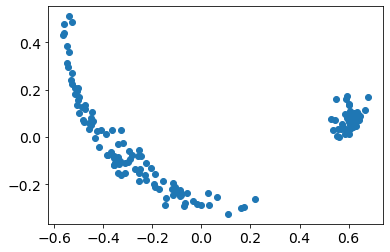

In [ ]:
plt.scatter(*X_kpca.T)

Veamos como eso se comporta con un conjunto de datos más complejos:

### El pionono (_Swiss Roll_)

In [ ]:
from sklearn.datasets import make_swiss_roll

X, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Este conjunto de datos es un plano enrollado, que es más complicado *decomponer*

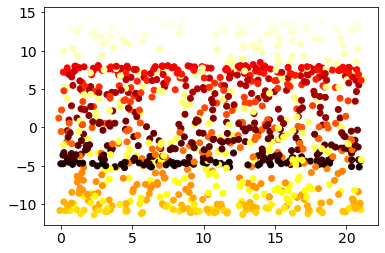

In [ ]:
plt.scatter(X[:, 1], X[:, 2], c=z,  cmap=plt.cm.hot)

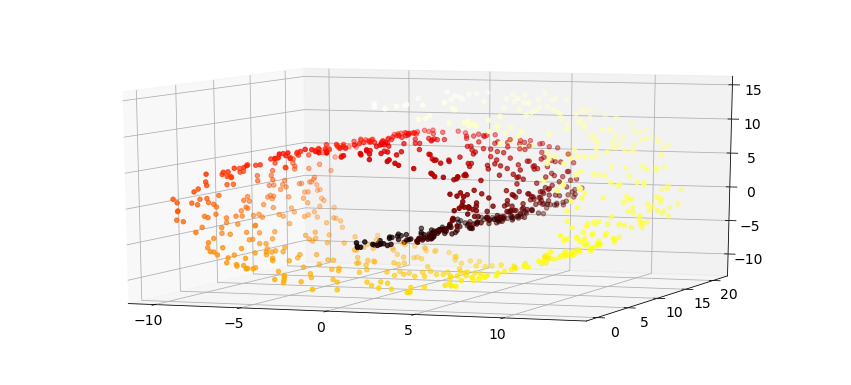

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Comparemos los resultados de distintos _kernels_

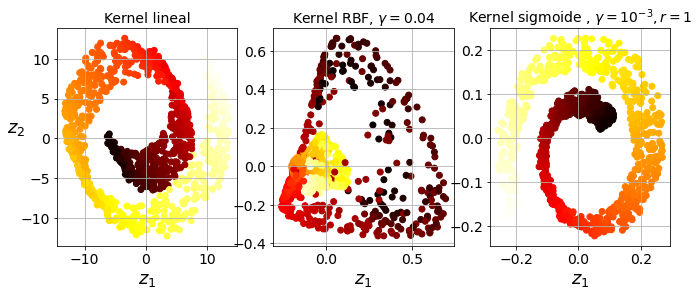

In [ ]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) #equivalente a PCA(n_components=2)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Kernel lineal"),
                            (132, rbf_pca, "Kernel RBF, $\gamma=0.04$"),
                            (133, sig_pca, "Kernel sigmoide , $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()